# Markov chain Monte Carlo

## Quelques aspects techniques avant de commencer

Il est très important de faire tourner la section ci-dessous, même si d'un point de vue pratique elle ne fait que préparer les instruments dont nous allons nous servir plus tard dans le document. Dans ce notebook, il est important d’exécuter `set.seed`, car nous allons effectuer une série d’opérations stochastiques qui peuvent légèrement varier à chaque exécution. Ainsi, si nous voulons que le code produise exactement les mêmes résultats à chaque fois — pour garantir la reproductibilité — il est nécessaire de fixer la graine aléatoire avec `set.seed()`.

In [ ]:
# Installation des packages, à faire une seule fois
Sys.setenv(LANG = "en")
# install.packages("ggplot2")
# install.packages("tidyverse")
# install.packages("HDInterval")

# Chargement des packages
library(ggplot2)
library(tidyverse)
library(HDInterval)

set.seed(1234)
darkred <- "#8B0000"

## La vraisemblance marginale

La vraisemblance marginale mesure à quel point le modèle complet (paramètres + données) explique bien les données observées, en tenant compte de toutes les valeurs possibles des paramètres, pondérées par leur probabilité a priori.

Autrement dit, pour un modèle avec un paramètre $\theta$, la vraisemblance marginale est une moyenne pondérée de la vraisemblance sur toutes les valeurs possibles de $\theta$. La vraisemblance marginale permet d'avoir une mesure exprimant à quel point un modèle décrit bien les données, et ce indépendamment de la valeur que les paramètres du modèle peuvent prendre.

La vraisemblance marginale est calculée comme une intégrale. Dans notre cas, elle est formalisée comme suit :

$$ P(x) = \int d\theta \  P(x \mid \theta) \cdot P(\theta) $$

### Exemple d'intégration numérique à la main

Dans le chapitre sur les priors, nous avons calculé la distribution a posteriori en utilisant la loi bêta et sa constante de normalisation. Ici, nous allons calculer la même distribution a posteriori en utilisant l'intégration numérique.

Nous allons reprendre le même exemple : dix personnes ont suivi le traitement, et trois d’entre elles ont eu une rechute à six mois.

Nous utilisons un modèle basé sur une loi binomiale, avec un paramètre $\theta$ représentant la probabilité de rechute à estimer, et un prior défini par une loi bêta avec $\alpha = \beta = 2$.

In [7]:
# Données
k <- 3
n <- 10

# Hyperparamètres du prior
alpha <- 2
beta <- 2

# Espace des paramètres à explorer (variant de 0 à 1 avec des pas de 0,002)
p <- seq(0, 1, .002)

À partir de cela, nous allons construire une fonction qui, pour chaque valeur du paramètre, multiplie la vraisemblance (calculée avec un modèle binomial) par le prior (défini à l’aide d’une loi bêta).

Cette opération correspond au numérateur dans la formule de Bayes, c’est-à-dire à la partie qui combine ce que nous savons avant d'observer les données (le prior) et ce que nous apprenons avec les données (la vraisemblance). Nous pouvons l'implémenter comme suit :

In [17]:
# Numérateur dans la forumle de Bayes : vraisemblance * prior
numerator <- function(p) dbinom(k, n, p) * dbeta(p, alpha, beta)

Nous pouvons représenter graphiquement cette distribution :

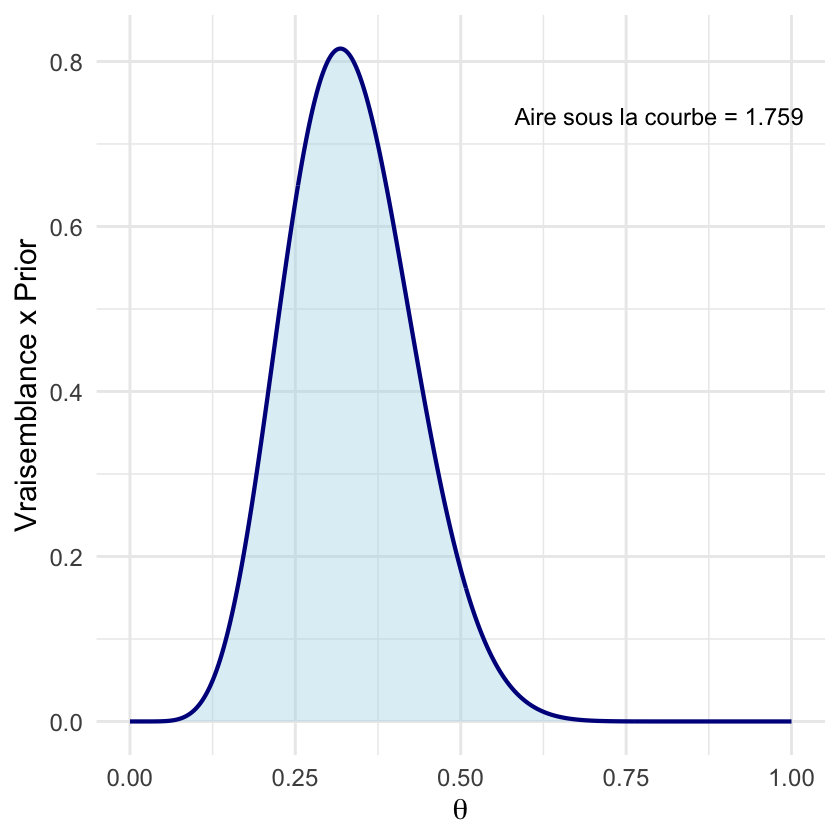

In [48]:
# Mettre l'ensemble dans une dataframe
df <- data.frame(prob = p, num = numerator(p))

aire_courbe <- integrate(post, 0, 1)$value

# Faire le graphique
ggplot(df, aes(x = prob, y = num)) +
  geom_area(fill = "lightblue", alpha = 0.4) +
  geom_line(color = "darkblue", linewidth = 1.2) +
  annotate("text", x = max(df$prob) * 0.8, y = max(df$num) * 0.9,
           label = paste0("Aire sous la courbe = ", round(aire_courbe, 3)),
           size = 5, color = "black") +
  labs(
    x = expression(theta),
    y = "Vraisemblance x Prior"
  ) +
  theme_minimal(base_size = 18)

Vous pouvez voir que cette distribution n'est pas une fonction de densité valide, car son intégrale ne correspond pas à 1. Pour obtenir une distribution a posteriori qui représente une fonction de densité valide, il nous faut cette fameuse constante de normalisation $P(D)$.

Pour l'obtenir, nous devons d'abord calculer l'intégrale de cette distribution. Comme il s'agit d'une intégrale simple, nous pouvons faire appel à la fonction `integrate` :

In [19]:
# Dénominateur (aire sous la courbe)
denominator <- integrate(numerator, 0, 1)$value

Ensuite, il suffit de diviser le numérateur (vraisemblance × prior) par la valeur de l'intégrale :

In [20]:
# Postérieur
posterior <- numerator(p) / denominator

Si nous représentons graphiquement cette distribution, nous pouvons voir qu'il s'agit bien d'une fonction de densité valide, et que son intégrale est égale à 1 :

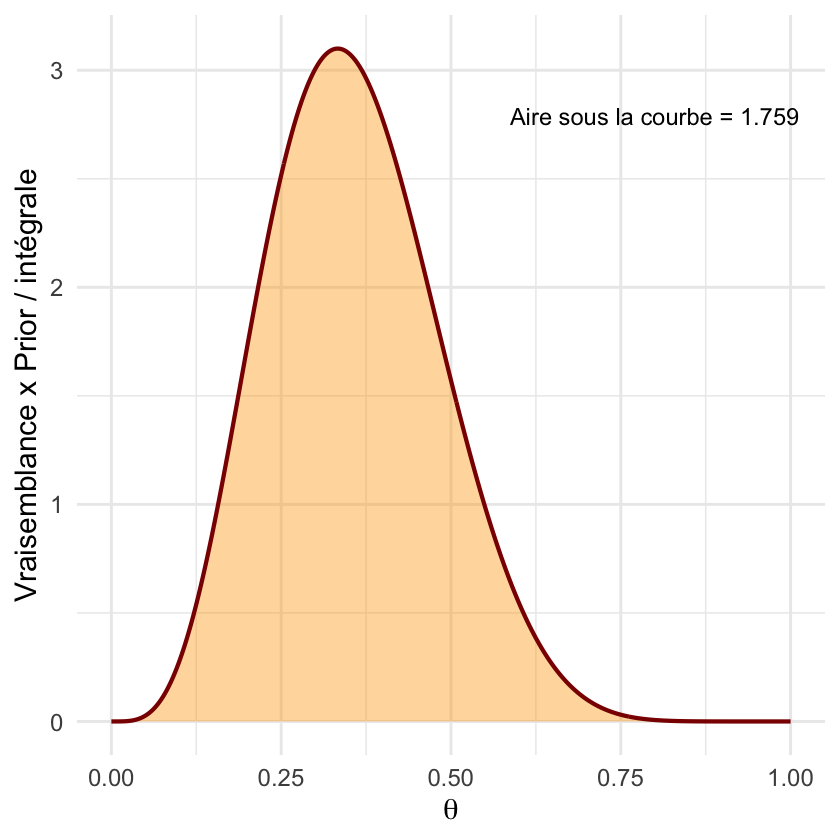

In [27]:
# Mettre l'ensemble dans une dataframe
df <- data.frame(prob = p, post = posterior)

# calcule de l'intégrale du posterior
post <- function(p) numerator(p) / denominator
aire_courbe <- integrate(post, 0, 1)$value

# Faire le graphique
ggplot(df, aes(x = prob, y = post)) +
  geom_area(fill = "orange", alpha = 0.4) +
  geom_line(color = "darkred", linewidth = 1.2) +
  annotate("text", x = max(df$prob) * 0.8, y = max(df$post) * 0.9,
           label = paste0("Aire sous la courbe = ", round(aire_courbe, 3)),
           size = 5, color = "black") +
  labs(
    x = expression(theta),
    y = "Vraisemblance x Prior / intégrale"
  ) +
  theme_minimal(base_size = 18)

Comme confirmation, vous pouvez constater que cette distribution correspond exactement à ce que nous avons calculé en utilisant la loi bêta comme constante de normalisation dans le chapitre sur les priors.

[1] 5
[1] 9


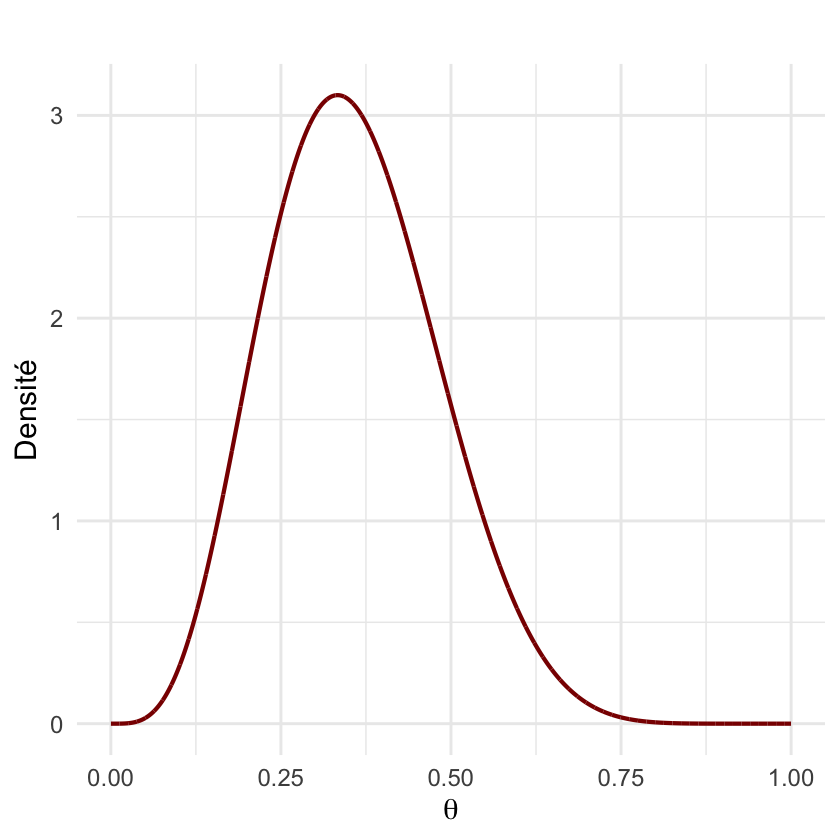

In [28]:
# Hyperparamètres de la distribution a priori
alpha_pr <- 2
beta_pr <- 2

# Données
k <- 3
n <- 10

# Hyperparamètres de la distribution a posteriori
alpha <- alpha_pr + k
beta <- beta_pr + n - k

print(alpha)
print(beta)

# Create a grid of values between 0 and 1
x <- seq(0.0001, 0.9999, by = 0.0001)
y <- dbeta(x, alpha, beta)

samples <- rbeta(10000, alpha, beta)

# Données pour le graphique
df <- data.frame(x = x, y = y)

# Faire le graphique
ggplot(df, aes(x = x, y = y)) +
  geom_line(color = "darkred", linewidth = 1.2) +
  labs(title = "",
       x = expression(theta),
       y = "Densité") +
  theme_minimal(base_size = 18)

## L'approximation de la distribution a posteriori par MCMC

Il n'est pas toujours possible d'obtenir la constante de normalisation en calculant l'intégrale. En particulier, le calcul est compliqué (voir impossible) dans le cas d'intégrales multiples. Historiquement, cela a constitué l'obstacle majeur dans l'implémentation des méthodes Bayésiennes. En effet, même dans le cas d'un modèle parmi les plus simples utilisés en psychologie expérimentale comme la régression linéaire simple, 3 paramètres doivent être estimés ($\beta_0$,$\beta_1$, $\sigma$), ce qui nécessite déjà le calcul d'une intégrale multidimensionnelle.

La développement des méthodes **Markov chain Monte Carlo** (MCMC) a permis une augmentation importante dans l'application des statistiques Bayésiennes.

L'idée clef des méthodes de *Monte Carlo* est d'utiliser le hasard pour résoudre des problèmes complexes qui ne peuvent pas être résolus par le calcul. Pour comprendre cette idée, imaginez l'exemple suivant : après une forte pluie, votre jardin est couvert par de grandes flaques de boue. Pour écrire à votre assurance, vous voulez quantifier la proportion de votre jardin qui est couverte par la boue, mais cela est très compliqué à calculer. Vous faites alors une estimation de la manière suivante : vous jetez $1000$ petits cailloux partout dasn le jardin, et vous comptez combien de cailloux tombent dans la boue. Si, par exemple, $750$ cailloux sont dans la boue, vous pouvez conclure qu'environ $75%$ du jardin est couvert par de la boue. En d'autres mots, l'idée derrière les méthodes Monte Carlo consiste à utiliser des tirages aléatoires pour estimer une quantité difficile à calculer autrement.

Les méthodes de Monte Carlo on été développées pendant le Seconde Guerre mondiale, dans le cadre du projet Manhattan (dans le laboratoire Los Alamos) cherchant à construire la première bombe atomique. L'idée des méthodes de Monte Carlo vient du physicien Stanislaw Ulam qui, avec l'aide de John von Neumann, ont imaginé une méthode consistant à faire de nombreux tirages aléatoires pour simuler des phénomènes physiques comme la diffusion des neutrons. Le nom "Monte Carlo" vient du célèbre casino de Monaco. Après la guerre, les chercheurs et chercheuses de Los Alamos ont continué à s’intéresser aux systèmes physiques complexe, et le dévelopement des méthodes MCMC prend un détour important en 1953 avec la publication d’un article écrit par Nicholas Metropolis, **Arianna Rosenbluth**, Marshall Rosenbluth, Augusta Teller et Edward Teller. Cet article présente ce qu’on appelle aujourd’hui l’algorithme de Metropolis, une version des méthodes de Monte Carlo qui utilise des chaines de Markov à la place des tirages complètement aléatoires. Cet algorithme est devenu la base du MCMC (Monte Carlo par chaînes de Markov), la méthode utilisée aujourd’hui dans les statistiques Bayésiennes pour l'approximation de la distribution a posteriori.

Bien que l’algorithme porte le nom de Metropolis, c’est en réalité Arianna Rosenbluth qui a écrit le code informatique et réalisé les premières simulations. Elle a joué un rôle central dans la mise en œuvre pratique de l’algorithme, en programmant les calculs sur les premiers ordinateurs de Los Alamos, à une époque où la programmation demandait une grande rigueur et une expertise technique exceptionnelle.

Les MCMC permettent d'approximer la distribution a posteriori sans devoir passer par l'intégration numérique. Ces méthodes utilisent des méthodes stochatisques (i.e., marche aléatoire) pour une série de valeurs de paramètres. Plus l'on génère de paramètres, plus la distribution de ces paramètres converge vers une distribution d'équilibre. Cette distribution d'équilibre correspond à la distribution a posteriori que l'on cherche à estimer.

Pour générer ces valeurs, des marches aléatoires (*random walk*) sont utilisées dans les MCMC pour explorer l'espace des paramètres (par exemple, les valeurs possibles de $\theta$). Une marche aléatoire est un processus stochastique (c’est-à-dire basé sur le hasard) dans lequel on se déplace pas à pas, en choisissant à chaque pas une nouvelle position au hasard, autour de la position précédente. 

Cette marche aléatoire est dit *Markovienne*, car chaque pas au moment ($t$) dépend du pas précédant ($t-1$) mais **ne dépend pas des autres pas faits dans le passé** (e.g., $t-2$, $t-3$, $t-4$, etc).

On utilise le terme *chaîne* qui souligne également le fait que chaque pas (i.e., chaque valeur générée par l'algorithme) dépend du pas précédant : les valeurs générées sont liées les unes aux autres, formant une suite ordonnée d'états où chaque état dépend du précédent.

Dans l'algorithme de Metropolis, nous pouvons distinguer 4 étapes :

- **1) Définir l'état de départ :**  Nous allons toujours partir d'une valeur possible du paramètre dont on cherche à estimer la distribution a posteriori. Cela est typiquement défini comme le point de départ de la chaîne de Markov ou la valeur initale.
  
- **2) Définir le prochain état possible :** Nous proposons de nous éloigner de la valeur actuelle du paramètre (*valeur actuelle*) vers une nouvelle valeur du paramètre. Nous ajoutons à cette valeur actuelle une valeur aléatoire provenant, par exemple, d'une distribution normale avec une certaine variance. Nous appelons cela l'emplacement candidat (*valeur candidate*). 

- **3) Calculer le ratio entre le posterior de la valeur actuelle et de la valeur candidate :** Le ratio est calculé de la manière suivante : $$R = \frac{\text{posterior(valeur candidate)}}{\text{posterior(valeur actuelle)}}$$ Cette étape est particulièrement utile dans le calcul de la distribution a posteriori car la probabilité des données ($P(D)$) apparaît de manière identique au numérateur et au dénominateur du ratio $R$ et donc s'annulle. Le calcul du ratio $R$ dans le MCMC se fait donc sans passer par le calcul d'une intégrale. Plus la valeur de $R$ est grande, plus la valeur candidate a une plus grande vraisemblance par rapport à la valeur actuelle.

- **4) Décider si bouger vers la valeur candidate ou rester :**  Nous tirons au hasard un numéro $X$ entre 0 et 1 (*random spin*). Si ce numéro est plus grand que le ratio $R$, alors nous bougeons vers la valeur candidate. Sinon, nous restons sur la valeur actuelle.


## Exemple de l'algorithme de Metropolis avec R

Nous pouvons reprendre exactement le même exemple pour illustrer le fonctionnement de l'algorithme de Metropolis et voir comment il fonctionne pas à pas avec `R`. Le code ci-dessous est adapté du code du Dr. Olivier Gimenez. Vous pouvez trouver plus d’informations sur ce thème sur son site (https://github.com/oliviergimenez/Bayesian_Workshop/tree/master) si vous souhaitez aller plus loin sur ce sujet : les explications sont d’excellente qualité et accompagnées de vidéos en français.


### Définir des données

Ici, j’ai simplement modifié le code pour l’adapter à notre exemple de base. Tout d’abord, il faut définir les données que nous avons, comme suit : 

In [29]:
# Données
k <- 3
n <- 10

### Définir les fonctions de vraisemblance, du prior et du posterior

Nous allons maintenant définir les fonctions de vraisemblance, du prior et du posterior.  


Avant cela, nous devons faire une petite modification par rapport à ce que nous avons vu jusqu’à présent.

Nous allons travailler avec les logarithmes de la vraisemblance et du prior. Cette transformation permet de remplacer les opérations multiplicatives (souvent utilisées en probabilités) par des opérations additives, ce qui est plus stable numériquement et plus facile à implémenter avec `R`. Concrètement, cela signifie que nous allons modifier la formule de Bayes classique qui s’écrit normalement ainsi :

$$
P(\theta \mid D) = \frac{P(D \mid \theta) \cdot P(\theta)}{P(D)}
$$

Nous prenons le logarithme de chaque terme. Comme le logarithme d’un produit est la somme des logarithmes, nous pouvons écrire la formule de Bayes comme suit :

$$
\log P(\theta \mid D) = \log P(D \mid \theta) + \log P(\theta) - \log P(D)
$$

Cette forme additive est particulièrement utile en programmation car elle évite les erreurs d’arrondi dues à la multiplication de très petits nombres. Dans le cas specifique de l'algorithme de Metropolis, cela simplifie les calculs dans la comparaison des ratios (que nous verrosns ensuite en détail).

Nous définissons d'abord la fonction qui nous donnera le log de la vraisemblance. Il s'agit toujours d'une binomiale (`dbinom`), mais nous calculons cette fois le logarithme de la vraisemblance, en spécifiant `log = TRUE` :

In [30]:
# Log-likelihood function
loglikelihood <- function(x, p){
  dbinom(x = x, size = n, prob = p, log = TRUE)
}

Nous faisons de même pour le prior.  

Il s'agit toujours d'une loi bêta avec $ \alpha = \beta = 2 $, transformée en logarithme :

In [32]:
# Densité a priori
logprior <- function(p){
  dbeta(p,2,2, log = TRUE)
}

Enfin, nous définissons la fonction pour le posterior. Ici, vous pouvez remarquer que la probabilité des données `log(Pr(D))` est mise en commentaire dans le code. Cela est possible car dans l’algorithme de Metropolis, nous allons plutôt comparer des ratios entre différentes valeurs du posterior. Comme nous l'avons vu auparavant, dans ces ratios la probabilité des données $P(D)$  apparaît à la fois au numérateur et au dénominateur, donc il s’annule automatiquement. C’est un avantage majeur de cet algorithme (et des MCMC en général) : il nous permet d'éviter le calcul de l’intégrale. 

Ainsi, nous pouvons travailler avec le logarithme du posterior non normalisé, sans avoir à calculer l’évidence.

In [34]:
# Fonction de densité de probabilité (échelle log) 
posterior <- function(x, p){
  loglikelihood(x, p) + logprior(p) # - log(Pr(data)) 
}

### Définir la fonction qui propose la nouvelle valeur

La fonction `move` est la fonction que l'on utilise pour proposer la valeur candidate.

- la variable `away` détermine de combien d'unité l'on se déplace
- `logitx` transforme la valeur du paramètre avec une logistique simplement pour y ajouter de la variance aléatoire à partir d'une distribution normale `rnorm` centrée sur 0. Ceci signifie qu’elle a autant de chances de tirer une valeur positive que négative. Concrètement, cela nous permet de respecter un postulat de base de l'algorithme de Metropolis qui est que, dans la marche aléatoire, la direction de chaque pas doit être dans 50% des cas à gauche et dans 50% des cas à droite. Cette symétrie gauche/droite vient de la distribution normale centrée sur 0 utilisée pour proposer de nouvelles valeurs candidates. Dans le code ci-dessous, cela est implicite : comme la distribution normale est symétrique autour de zéro, il y a $50 %$ de chances que la valeur candidate proposée soit plus grande que la valeur actuelle (mouvement vers la droite) et $50 %$ de chances qu’elle soit plus petite (mouvement vers la gauche).
- la transformation `plogis` remet simplement la valeur sur son échelle initiale entre 0 et 1 (c'est la transformation inverse de la logistique).

In [35]:
# Proposer une valeur candidate
move <- function(x, away = .2){ 
  logitx <- log(x / (1 - x))                      # transform x to logit scale
  logit_candidate <- logitx + rnorm(1, 0, away)   # add noise from normal distribution
  candidate <- plogis(logit_candidate)            # transform back to [0, 1] scale
  return(candidate)
}

### Définition de de la marche aléatoire

Dans cette fonction `metropolis`, nous allons définir de nombre de pas que nous allons faire (`steps`) et la valeur initiale du paramètre (`inits`).

À chaque pas (repété dans la boucle `for`) on :
- propose une nouvelle valeur candidate (avec la fonction `move`)
- calcule la valeur a posteriori de la valeur candidate et la valeur actuelle (`pstart` et `pprev`)
- calcule le log ratio (`logR`) avec une opération additive (et non pas multiplicative car le posterior est en log)
- transforme le log ratio avec une exponotielle (`exp`) pour avoir une valeur entre 0 et 1
- décide si accepter ou pas la nouvelle valeur avec le *random spin*

In [36]:
metropolis <- function(steps = 100, inits = 0.5){
  
  # pre-alloc memory
  theta.post <- rep(NA, steps)
  
  # start
  theta.post[1] <- inits
  
  for (t in 2:steps){
    
    # propose candidate value for prob of success
    theta_star <- move(theta.post[t-1])
    
    # calculate ratio R
    pstar <- posterior(k, p = theta_star)  
    pprev <- posterior(k, p = theta.post[t-1])
    logR <- pstar - pprev
    R    <- exp(logR)
    
    # decide to accept candidate value or to keep current value
    accept <- rbinom(1, 1, prob = min(R, 1))
    theta.post[t] <- ifelse(accept == 1, theta_star, theta.post[t-1])
  }
  theta.post
}


### Implémentation de l'algorithme de Metropolis 

Dans le code ci-dessous qui implémente l'algorithme de Metropolis, nous allons définir le nombre de pas (`steps`) et la valeur initiale de la chaîne (`inits`). Ici, nous allons construire trois chaînes (`chain1`, `chain2`, `chain3`) avec trois points de départ différents (`0.2`,`0.5`,`0.7`). Attention : selon le nombre de pas, cela peut prendre un certain temps. Dans ce code, vous pouvez tester quelle est l'impact du nombre de pas sur l'estimation de la distribution a posteriori.

In [37]:
steps <- 10000

chain1 <- metropolis(steps = steps, inits = 0.2)
chain2 <- metropolis(steps = steps, inits = 0.5)
chain3 <- metropolis(steps = steps, inits = 0.7)

median(chain1)
median(chain2)
median(chain3)

[1] 0.3091795

[1] 0.3083708

[1] 0.3102495

Ensuite, nous mettons les valeurs dans une dataframe pour faire des représentations graphiques.

In [ ]:
df <- data.frame(iter = rep(1:steps, 3), 
                 value = c(chain1, chain2, chain3),
                 chain = c(rep("chain1", steps),
                           rep("chain2", steps),
                           rep("chain3", steps)))

Représentation graphique des chaînes :

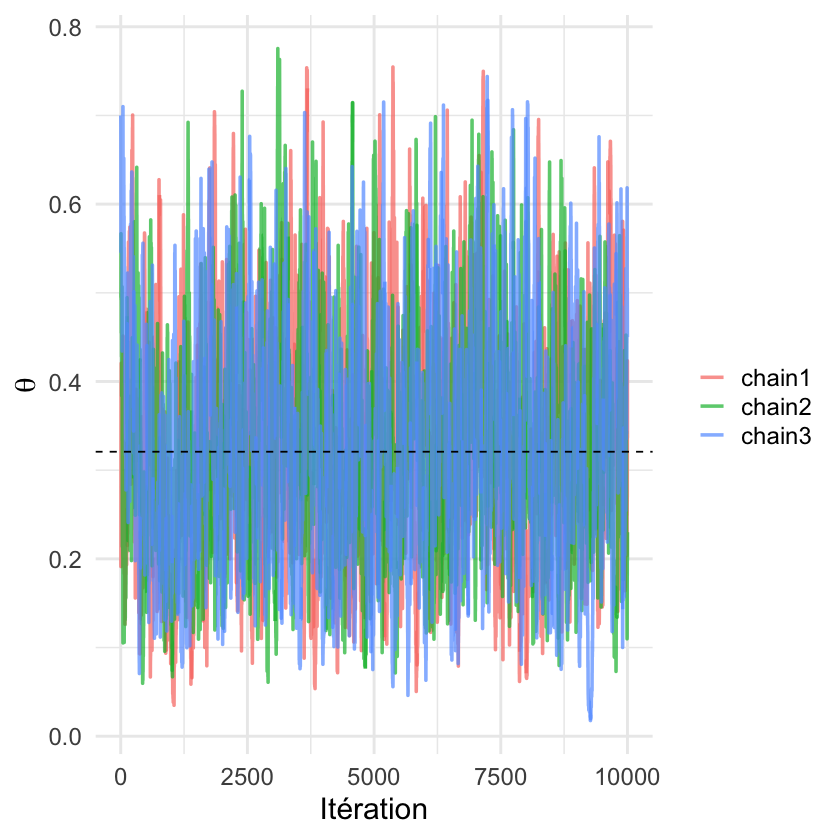

In [40]:
chain_plot <- df %>%
  mutate(posterior_mean = mean(value)) %>%
  ggplot(aes(x = iter, y = value, group = chain, color = chain)) +
  geom_line(size = 1, alpha = 0.7) +
  geom_hline(aes(yintercept = posterior_mean), linetype = 2) +
  labs(color = "", x = "Itération", y = expression(theta)) +
  theme_minimal(base_size = 18)

chain_plot

Représentation graphique de l'approximation des distributions a posteriori estimées :

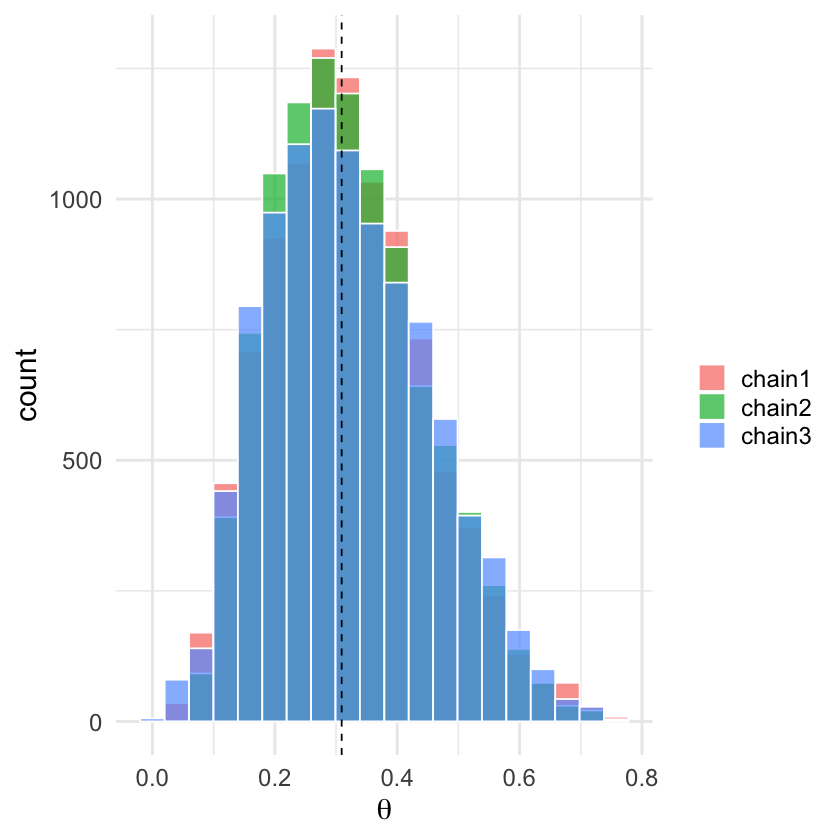

In [41]:
# Histogramme
histogram_mcmc <- df %>%
  mutate(posterior_mean = median(value)) %>%
  ggplot(aes(x = value, fill = chain)) +
  geom_histogram(color = "white", bins = 20, alpha = 0.7, position = "identity") + 
  geom_vline(aes(xintercept = posterior_mean), linetype = 2) +
  labs(x = expression(theta), fill = "") +
  theme_minimal(base_size = 18)

histogram_mcmc

Sur la base de cela, nous pouvons aussi faire le graphique de la densité de probabilité comme suit :

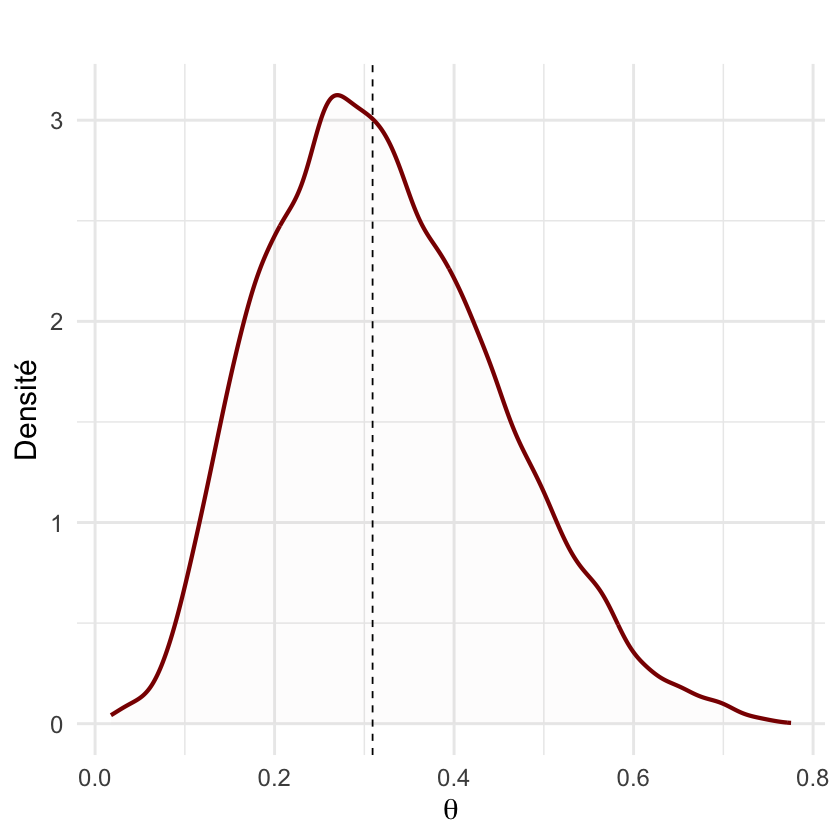

In [42]:
density_mcmc <- df %>%
  mutate(posterior_mean = median(value)) %>%
  ggplot(aes(x = value)) +
  geom_density(fill = darkred, alpha = 0.01, color = darkred, linewidth = 1.2) +
  geom_vline(aes(xintercept = posterior_mean), linetype = 2) +
  labs(title = "",
       x = expression(theta),
       y = "Densité") +
  theme_minimal(base_size = 18)

density_mcmc

Et nous pouvons calculer la valeur médiane et l'intervalle HDI de cette distribution a posteriori approximée par MCMC :

In [43]:
posterior_median <- median(df$value)
posterior_hdi <- hdi(df$value, credMass = 0.95)

posterior_median
posterior_hdi

[1] 0.3091978

lower      upper 
0.09871732 0.57377766 
attr(,"credMass")
[1] 0.95

## Notes sur Metropolis

La performance de l’algorithme de Metropolis pour estimer la distribution postérieure dépend fortement des données utilisées. En effet, ce sont les données qui influencent la stabilité de l’estimation de la vraisemblance, un élément clef dans le calcul du ratio d'acceptation. Ce ratio compare la vraisemblance et la densité a priori entre deux propositions successives, et c’est ce mécanisme qui guide la construction de la chaîne de Markov. Si les données conduisent à une estimation instable de la vraisemblance — par exemple en raison d’un faible signal ou d’une grande incertitude — alors le ratio devient bruité, ce qui nuit à la qualité de l’échantillonnage. À l’inverse, des données informatives permettent une estimation plus précise de la vraisemblance, stabilisent le ratio et améliorent la convergence de la chaîne vers la distribution cible. Vous pouvez tester cet effet en changeant les données : essayez d'observer l'impact sur les chaînes (en changeant par exemple le nombre de pas nécessaires) avec des échantillons plus grands, comme par exemple $n = 100$ et $k = 30$.